<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-handling" data-toc-modified-id="Dataset-handling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset handling</a></span></li><li><span><a href="#Simple-psychometric-fits" data-toc-modified-id="Simple-psychometric-fits-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple psychometric fits</a></span><ul class="toc-item"><li><span><a href="#Percent-Correct" data-toc-modified-id="Percent-Correct-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Percent Correct</a></span></li></ul></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Single-predictor" data-toc-modified-id="Single-predictor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Single predictor</a></span><ul class="toc-item"><li><span><a href="#Signed-coherence" data-toc-modified-id="Signed-coherence-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Signed coherence</a></span></li></ul></li><li><span><a href="#More-predictors" data-toc-modified-id="More-predictors-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>More predictors</a></span><ul class="toc-item"><li><span><a href="#Single-subject" data-toc-modified-id="Single-subject-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Single subject</a></span></li></ul></li></ul></li></ul></div>

<!--
IRdisplay::display_html(file='../code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

# Fitting psychometric functions

This notebook analyzes data from `Pilot 19` datasets.

In [1]:
library(data.table)
library(ggplot2)        
source('../../R/R_functions.r')

In [2]:
# define constants for notebook
SUBJ <- 19

# ref for the following hard-coded values: 
# https://github.com/TheGoldLab/Task_SingleCP_DotsReversal/commit/6b56bbaf9d2869ac390617e58cb92f56f7013bfc
# psubj <- c(60,2,0.5,0.001)    # pilot 15
# psubj <- c(60,2,0.5,0.001)    # pilot 16
# psubj <- c(38,2,0.5,0.001)    # pilot 17
# psubj <- c(17.5,2,0.5,0.001)  # pilot 18
psubj <- c(60,2,0.5,0.001)    # pilot 19

names(psubj) <- c('threshold','slope','guess','lapse')

QuestParams <- list(psubj) 
names(QuestParams) <- c(toString(SUBJ))

# recall, to access threshold of subject 13, type
# th13 <- QuestParams[['13']]['threshold']

# plot-specific constants
PLOT_TITLE_FONT_SIZE <- 18
PLOT_SUBTITLE_FONT_SIZE <- 13 
AXES_LABEL_FONT <- 14
AXES_FONT <- 13

ERROR_WIDTH <- 4
SMALL_ERROR_WIDTH <- .01*ERROR_WIDTH

LINE_WIDTH <- 1.4
POINT_SIZE <- 2
SMALL_DOT_SIZE <- 1

In [3]:
mytheme <- theme(
    plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
    plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),            # subtitle
    plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),             # caption
    axis.title.x=element_text(size=AXES_LABEL_FONT),                     # X axis title
    axis.title.y=element_text(size=AXES_LABEL_FONT),                     # Y axis title
    axis.text.x=element_text(size=AXES_FONT),                            # X axis text
    axis.text.y=element_text(size=AXES_FONT)                             # Y axis text
    )

## Dataset handling

Let's load and inspect the dataset.

In [4]:
# load dataset
data <- fread('../../data/Pilot15-19/psychophysical_data.csv')
data <- data[pilotID==SUBJ]

# set some variables as factors
data[,`:=`(
    presenceCP=as.factor(presenceCP),
    choice=as.factor(choice),
    facVD=as.factor(viewingDuration)
    )
]

In [5]:
# define a 'signedCohLast' column that assigns a sign to the coherence based on the direction in the last epoch
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [6]:
str(data)

Classes ‘data.table’ and 'data.frame':	439 obs. of  13 variables:
 $ pilotID        : int  19 19 19 19 19 19 19 19 19 19 ...
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 1 2 2 1 2 2 2 2 2 2 ...
 $ correct        : logi  FALSE FALSE FALSE TRUE TRUE TRUE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ viewingDuration: num  0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 ...
 $ signedCoherence: num  39 -51 -59 -64 64 63 63 63 -63 -66 ...
 $ coherence      : num  39 51 59 64 64 63 63 63 63 66 ...
 $ choice_time    : num  1.411 0.643 0.483 1.179 0.611 ...
 $ exactVD        : num  0.406 0.424 0.391 0.407 0.407 ...
 $ facVD          : Factor w/ 4 levels "0.1","0.2","0.3",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ signedCohLast  : num  39 -51 -59 -64 64 63 63 63 -63 -66 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
print('first 6 rows of data.table')
head(data)

[1] "first 6 rows of data.table"


pilotID,taskID,validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,facVD,signedCohLast
19,1,1,left,FALSE,no,0.4,39,39,1.4111590,0.4060381,0.4,39
19,1,2,right,FALSE,no,0.4,-51,51,0.6431293,0.4237817,0.4,-51
19,1,3,right,FALSE,no,0.4,-59,59,0.4826772,0.3911044,0.4,-59
19,1,4,left,TRUE,no,0.4,-64,64,1.1790289,0.4067797,0.4,-64
19,1,5,right,TRUE,no,0.4,64,64,0.6106756,0.4067797,0.4,64
19,1,6,right,TRUE,no,0.4,63,63,0.4151014,0.4243167,0.4,63


## Simple psychometric fits 

### Percent Correct

Is the percent correct as a function of coherence value in the task node similar to the one estimated in the Quest node?

In [8]:
# steps
# 1. For each subject, get parameters of psychometric curve estimated by Quest
# 2. plot the curve
# 3. overlay data from task node, for appropriate viewing duration
# 4. overlay theoretical curve corresponding to the fitted logistic regression
# 5. plot everything

# The final plot should use a single data.table
# data[taskID==2]
# progress
# 1. complete
# 2. complete
# 3. complete

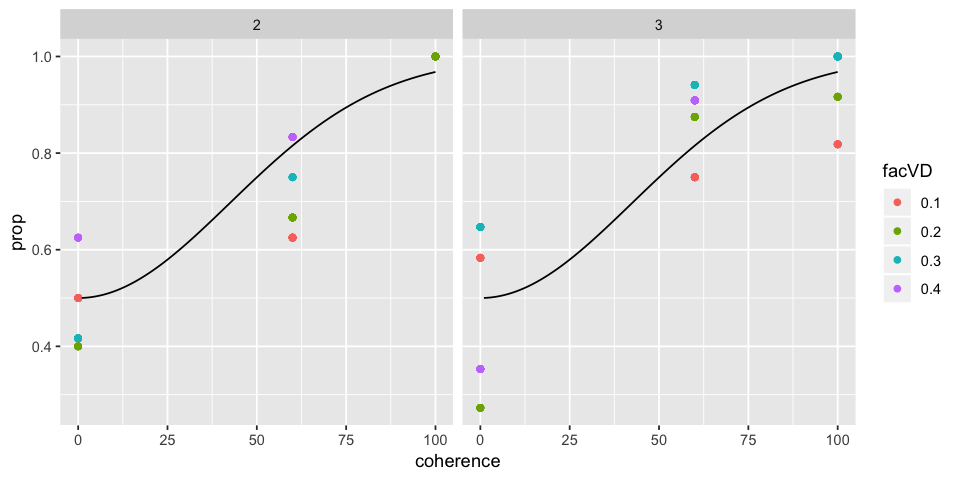

In [9]:
x <- seq(100)

for (subj in names(QuestParams)) {
    psychometric <- psi_corr(weibull, QuestParams[[subj]])
    y <- psychometric(x)
    questCurve <- data.table(x=x, y=y)
    
    # control output figure size
    options(repr.plot.width=8, repr.plot.height=4)

    pp <- ggplot(data[pilotID==subj & taskID > 1 & presenceCP=='no',
                      .(facVD, prop=sum(correct==TRUE)/.N),
                      by=.(coherence, viewingDuration, taskID)], 
                 aes(x=coherence, y=prop)) +
             geom_point(aes(col=facVD)) + 
             facet_grid(.~taskID) + 
             geom_line(aes(x=x, y=y), data=questCurve)
    plot(pp)
}

## Logistic regression

### Single predictor

#### Signed coherence
<a id="cohpred"></a>

We start by fitting our simplest logistic regression model, called **M1**
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{sc}_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x^\text{sc}$ is the signed coherence value.

And for now, let's only study task 2.

In [10]:
task <- '2'

In [11]:
# simplify existing dataset in order to consider 1 subject and 1 task:
single <- data[taskID==task]
# head(single)

In [12]:
# fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)
M1 <- glm(choice ~ signedCohLast, single, family=binomial())
M1


Call:  glm(formula = choice ~ signedCohLast, family = binomial(), data = single)

Coefficients:
  (Intercept)  signedCohLast  
      0.74787        0.01945  

Degrees of Freedom: 195 Total (i.e. Null);  194 Residual
Null Deviance:	    260.8 
Residual Deviance: 204.8 	AIC: 208.8

In [13]:
coherences <- seq(-100,100,10)
predictions <- my_logistic(coherences, linear_func(coef(summary(M1))))

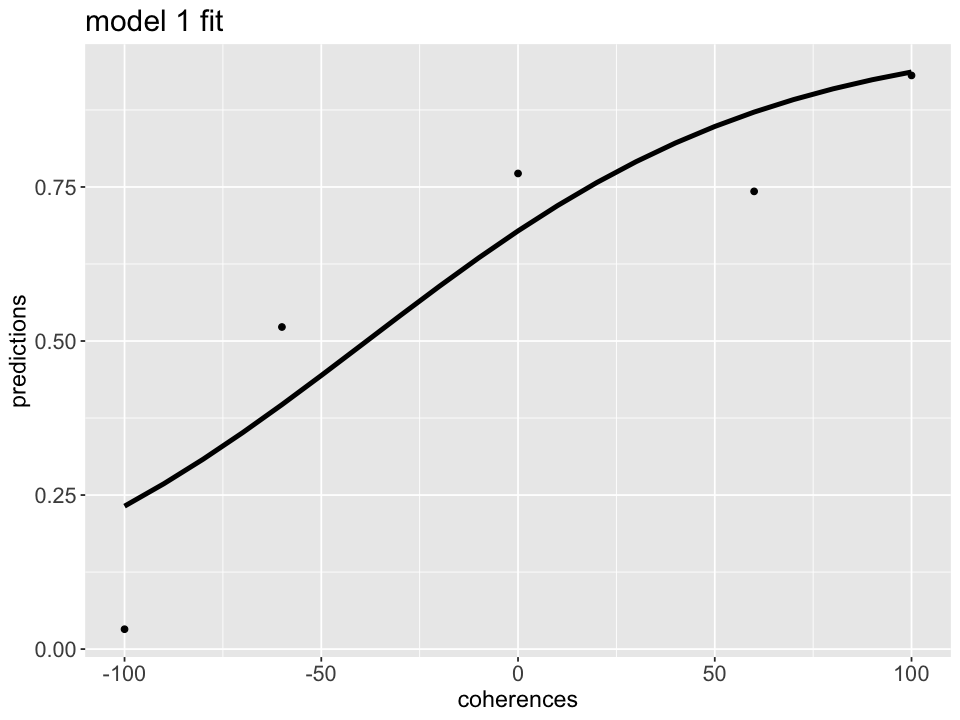

In [14]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data.table(coherences, predictions), aes(x=coherences, y=predictions)) +
    geom_line(size = 1.4) + 
    geom_point(aes(x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,.(propRight=sum(choice=='right')/.N),by=.(signedCohLast)]) +
    labs(title='model 1 fit') + 
    mytheme    

### More predictors
#### Single subject

Let's first try to fit what we call **Model 2**, or **M2**.
$$ \text{logit}(p_\text{right}) =\beta_0+
    \sum_{i\in\text{VDs}}\mathbb{1}_{\text{VD}_i}
    \beta^{VD\textsf{x}coh}_iX_{coh}$$

In [15]:
M2 <- glm(choice ~ signedCohLast:facVD, data=single, family=binomial())

In [16]:
M2


Call:  glm(formula = choice ~ signedCohLast:facVD, family = binomial(), 
    data = single)

Coefficients:
           (Intercept)  signedCohLast:facVD0.1  signedCohLast:facVD0.2  
               0.77627                 0.02268                 0.02547  
signedCohLast:facVD0.3  signedCohLast:facVD0.4  
               0.01141                 0.02359  

Degrees of Freedom: 195 Total (i.e. Null);  191 Residual
Null Deviance:	    260.8 
Residual Deviance: 200.5 	AIC: 210.5

We will overlay the fitted psychometric curves for each viewing duration:

In [17]:
# we gather all the predictions in a single data.table
factor_levels <- levels(single[,facVD])
num_factors = length(factor_levels)
coherence <- rep(coherences, times=num_factors)  # coherences defined in some cell above
VD <- c()
predictions <- c()

In [18]:
for (vd in factor_levels) {
    VD <- c(VD, rep(c(vd), times = length(coherences)))
    coef_names <- c("(Intercept)", paste("signedCohLast:facVD",vd,sep=''))
    fitted_betas <- coef(summary(M2))[coef_names, "Estimate"]
    eta <- linear_func(fitted_betas)
    predictions <- c(predictions, my_logistic(coherences, eta))
}

In [19]:
prediction_data <- data.table(coherence, VD, predictions)
prediction_data[,VD:=as.factor(VD)]

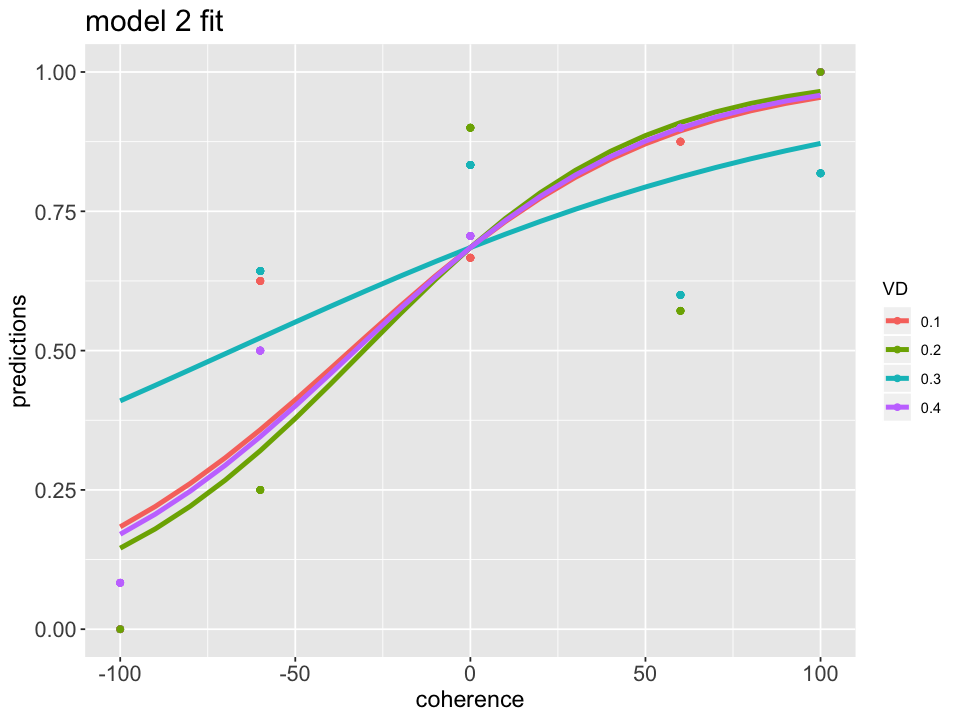

In [20]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(prediction_data, aes(x=coherence, y=predictions)) +
    geom_line(aes(col=VD), size = 1.4) + 
    geom_point(aes(col=facVD, x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,propRight:=sum(choice=='right')/.N,by=.(signedCohLast, facVD)]) +
    labs(title='model 2 fit') +
    mytheme    

Can we already select between M1 and M2?

We now tackle **Model 3**, or **M3**.
$$ \text{logit}(p_\text{right}) =\beta_0+
    \sum_{j\in\text{CPs}}\mathbb{1}_{\text{CP}_j} 
    \beta^{CP\textsf{x}coh}_jX_{coh}$$

In [21]:
M3 <- glm(choice ~ signedCohLast:presenceCP, data=single, family=binomial())
M3


Call:  glm(formula = choice ~ signedCohLast:presenceCP, family = binomial(), 
    data = single)

Coefficients:
                (Intercept)   signedCohLast:presenceCPno  
                   0.790727                     0.028990  
signedCohLast:presenceCPyes  
                   0.002954  

Degrees of Freedom: 195 Total (i.e. Null);  193 Residual
Null Deviance:	    260.8 
Residual Deviance: 187.2 	AIC: 193.2

In [22]:
# we gather all the predictions in a single data.table, just as for model 2
factor_levels <- levels(single[,presenceCP])
num_factors = length(factor_levels)
coherence <- rep(coherences, times=num_factors)  # coherences defined in some cell above
CP <- c()
predictions <- c()
for (cp in factor_levels) {
    CP <- c(CP, rep(c(cp), times = length(coherences)))
    coef_names <- c("(Intercept)", paste("signedCohLast:presenceCP",cp, sep=''))
    fitted_betas <- coef(summary(M3))[coef_names, "Estimate"]
    eta <- linear_func(fitted_betas)
    predictions <- c(predictions, my_logistic(coherences, eta))
}
prediction_data <- data.table(coherence, CP, predictions)
prediction_data[,CP:=as.factor(CP)]

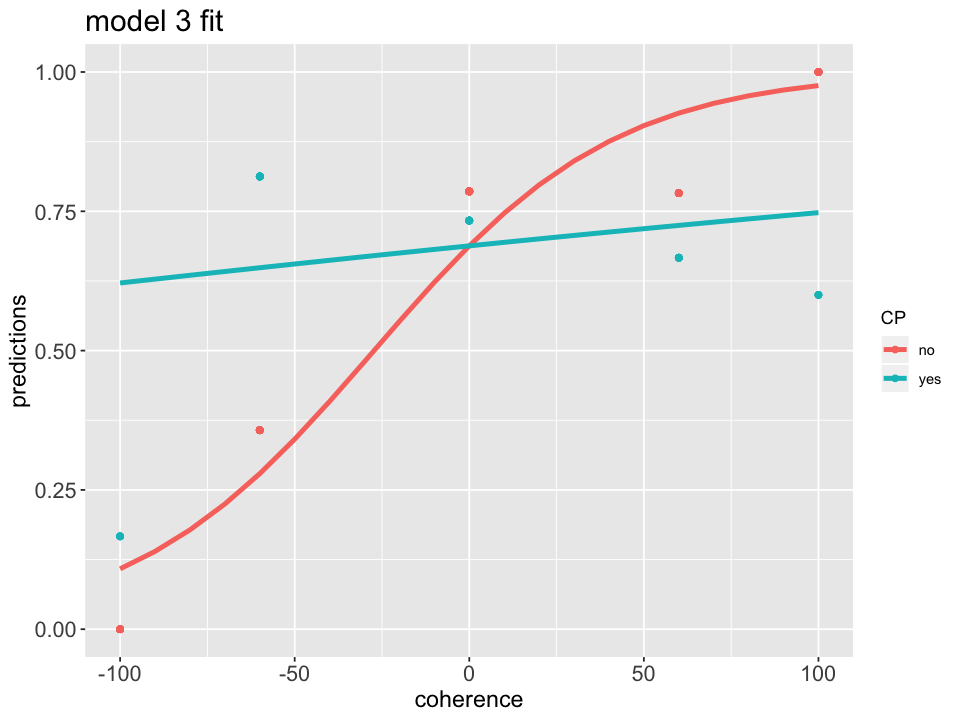

In [23]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(prediction_data, aes(x=coherence, y=predictions)) +
    geom_line(aes(col=CP), size = 1.4) + 
    geom_point(aes(col=presenceCP, x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,propRight:=sum(choice=='right')/.N,by=.(signedCohLast, presenceCP)]) +
    labs(title='model 3 fit') +
    mytheme   

Finally, let's fit **Model 4**, i.e. **M4**:
$$ \text{logit}(p_\text{right}) =
\beta_0 +
    \sum_{(i,j)\in\text{VDs}\times\text{CPs}}
    \left(
    \beta^{VD\textsf{x}coh}_i\mathbb{1}_{\text{VD}_i}+
    \beta^{CP\textsf{x}coh}_j\mathbb{1}_{\text{CP}_j}
    \right)
    X_{coh}$$

In [24]:
M4 <- glm(choice ~ facVD + signedCohLast:facVD + presenceCP + signedCohLast:presenceCP - 1, data=single, family=binomial())
M4


Call:  glm(formula = choice ~ facVD + signedCohLast:facVD + presenceCP + 
    signedCohLast:presenceCP - 1, family = binomial(), data = single)

Coefficients:
                   facVD0.1                     facVD0.2  
                    0.95406                      0.48596  
                   facVD0.3                     facVD0.4  
                    1.02812                      1.29280  
              presenceCPyes       facVD0.1:signedCohLast  
                   -0.33140                      0.02388  
     facVD0.2:signedCohLast       facVD0.3:signedCohLast  
                    0.02377                      0.03386  
     facVD0.4:signedCohLast  signedCohLast:presenceCPyes  
                    0.04807                     -0.03665  

Degrees of Freedom: 196 Total (i.e. Null);  186 Residual
Null Deviance:	    271.7 
Residual Deviance: 181.1 	AIC: 201.1

In model 4 above, I am not sure why the fit doesn't provide me for a pair of coefficients for the 'no' CP case...

In [25]:
anova(M1, M2, M3, M4)

Resid. Df,Resid. Dev,Df,Deviance
194,204.7988,NA,NA
191,200.4531,3,4.345662
193,187.1543,-2,13.298860
186,181.1441,7,6.010144
